In [357]:
import pandas as pd
from pandas.tools.plotting import autocorrelation_plot
import matplotlib.pylab as pylab
from statsmodels.tsa.arima_model import ARIMA
pylab.rcParams['figure.figsize'] = (10, 6)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


random intro to time-series

random intro to dataset

What is the data set?
------------------------
Prices and weather forecasts for the New York State power grid


Definitions:
------------

NYISO: New York Independent System Operator
LBMP: Locational Based Marginal Pricing


In [40]:
# load all the data
day_ahead_market = pd.read_csv('datasets/timeseries/day_ahead_market_lbmp.csv.gz')
real_time_market = pd.read_csv('datasets/timeseries/real_time_market_lbmp.csv.gz')
weather_forecast = pd.read_csv('datasets/timeseries/weather_forecast.csv.gz')

In [42]:
day_ahead_market['Time Stamp'] = pd.to_datetime(day_ahead_market['Time Stamp'], format='%m/%d/%Y %H:%M')
real_time_market['Time Stamp'] = pd.to_datetime(real_time_market['Time Stamp'], format='%m/%d/%Y %H:%M:%S')

In [56]:
weather_forecast['Forecast Date'] = pd.to_datetime(weather_forecast['Forecast Date'], format='%m/%d/%Y')
weather_forecast['Vintage Date'] = pd.to_datetime(weather_forecast['Vintage Date'], format='%m/%d/%Y')
weather_forecast['Vintage'] = weather_forecast['Vintage'].astype('category')

In [116]:
# insert some graphs here
dam_time_name = day_ahead_market.set_index(['Name', 'Time Stamp'])
rtm_time_name = real_time_market.set_index(['Name', 'Time Stamp'])

In [125]:
dam_nyc_lbmp = dam_time_name['LBMP ($/MWHr)']['N.Y.C.']
rtm_nyc_lbmp = rtm_time_name['LBMP ($/MWHr)']['N.Y.C.']

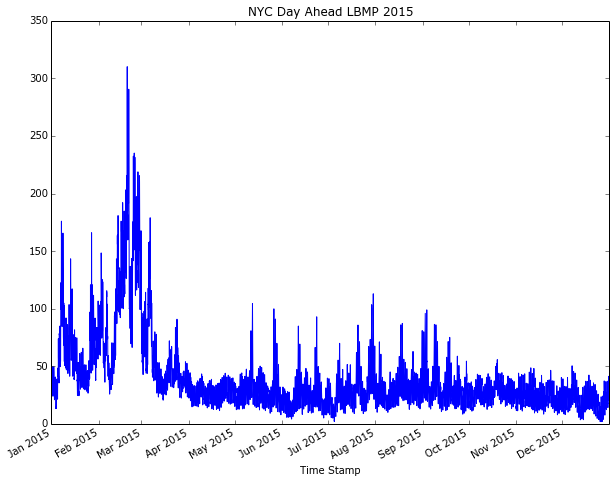

In [355]:
plt.figure(figsize=(10,8))
dam_nyc_lbmp.plot(title='NYC Day Ahead LBMP 2015')

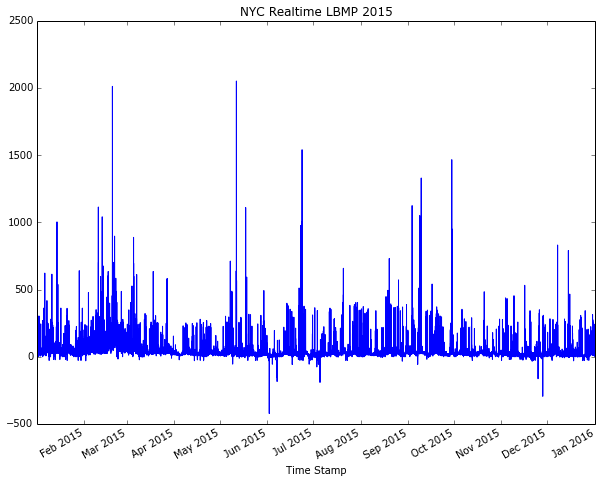

In [354]:
plt.figure(figsize=(10,8))
rtm_nyc_lbmp.plot(title='NYC Realtime LBMP 2015')

In [164]:
aligned_dam, aligned_rtm = rtm_nyc_lbmp.align(dam_nyc_lbmp, join='inner')

no_dup_al_dam = aligned_dam[~aligned_dam.index.duplicated(keep='first')]
no_dup_al_rtm = aligned_rtm[~aligned_dam.index.duplicated(keep='first')]

no_dup_al_dam.name = 'dam_lbmp'
no_dup_al_rtm.name = 'rtm_lbmp'

dam_rtm_df = pd.DataFrame([no_dup_al_dam, no_dup_al_rtm]).transpose()

lga_and_jfk_indexed = weather_forecast[(weather_forecast['Station ID'] == 'LGA') | (weather_forecast['Station ID'] == 'JFK')].set_index(['Forecast Date', 'Vintage Date', 'Vintage', 'Station ID'])
mean_nyc_indexed = lga_and_jfk_indexed.mean(level=[0,1,2])

mean_nyc = mean_nyc_indexed.reset_index()
actual_temp_df = mean_nyc[mean_nyc['Vintage'] == 'Actual'] \
    .groupby(['Vintage Date']).first() \
    .rename(columns=lambda x: 'Actual ' + x)

dam_rtm_act_df = dam_rtm_df.join(actual_temp_df, how='left').fillna(method='ffill').dropna()

In [310]:
daily_df = dam_rtm_act_df.resample('D', how='mean')

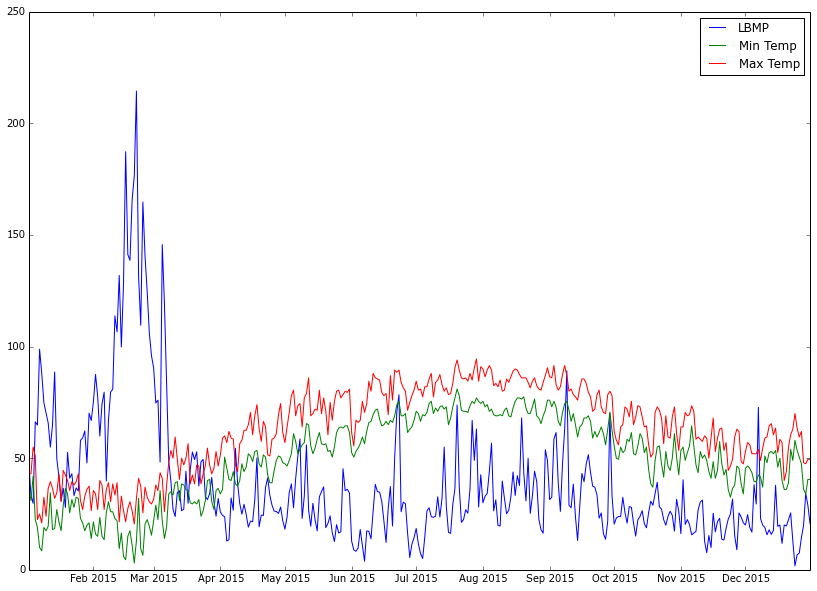

In [350]:
plt.figure(figsize=(14,10))
plt.plot_date(daily_df.index, daily_df['dam_lbmp'], '-', label='LBMP')
plt.plot_date(daily_df.index, daily_df['Actual Min Temp'], '-', label='Min Temp')
plt.plot_date(daily_df.index, daily_df['Actual Max Temp'], '-', label='Max Temp')
plt.legend()

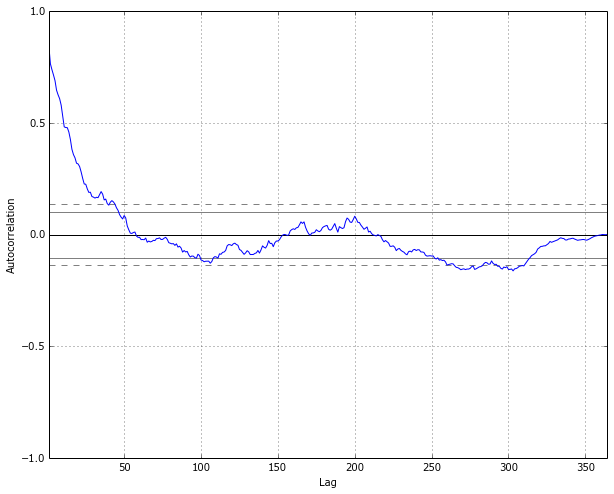

In [353]:
plt.figure(figsize=(10,8))
autocorrelation_plot(daily_df['dam_lbmp'])

In [440]:
m = ARIMA(daily_df['dam_lbmp'].values, [10,0,0], exog=daily_df['Actual Min Temp'].values, dates=daily_df.index.values)

In [441]:
results = m.fit(trend='c', disp=True)

In [442]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  364
Model:                    ARMA(10, 0)   Log Likelihood               -1505.374
Method:                       css-mle   S.D. of innovations             15.101
Date:                Sat, 16 Jan 2016   AIC                           3036.748
Time:                        17:22:03   BIC                           3087.411
Sample:                    01-02-2015   HQIC                          3056.884
                         - 12-31-2015                                         
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         63.1105      9.881      6.387      0.000        43.744    82.477
x1            -0.5038      0.147     -3.429      0.001        -0.792    -0.216
ar.L1.y        0.6295      0.052     12.102      0.000         0.528     0.731
ar.L2.y       -0.0061      0.062     -0.098      0.922        -0.128     0.116
ar.L3.y        0.1263      0.062      2.049      0.041         0.006     0.247
ar.L4.y        0.0360      0.062      0.580      0.562        -0.086     0.158
ar.L5.y        0.0979      0.062      1.577      0.116        -0.024     0.219
ar.L6.y       -0.0473      0.062     -0.761      0.447        -0.169     0.075
ar.L7.y        0.0455      0.062      0.733      0.464        -0.076     0.167
ar.L8.y        0.0525      0.062      0.851      0.396        -0.069     0.174
ar.L9.y        0.0608      0.062      0.985      0.325        -0.060     0.182
ar.L10.y      -0.1083      0.052     -2.071      0.039        -0.211    -0.006
                                    Roots                                     
==============================================================================
                  Real           Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.2061           -0.4803j            1.2982           -0.4397
AR.2            -1.2061           +0.4803j            1.2982            0.4397
AR.3            -0.7178           -1.0665j            1.2856           -0.3443
AR.4            -0.7178           +1.0665j            1.2856            0.3443
AR.5             0.1177           -1.1954j            1.2012           -0.2344
AR.6             0.1177           +1.1954j            1.2012            0.2344
AR.7             0.8612           -0.9010j            1.2464           -0.1286
AR.8             0.8612           +0.9010j            1.2464            0.1286
AR.9             1.0720           -0.0000j            1.0720           -0.0000
AR.10            1.3798           -0.0000j            1.3798           -0.0000
------------------------------------------------------------------------------
"""

In [443]:
predicted_prices = results.predict(10, 364, exog=daily_df['Actual Min Temp'].values, dynamic=False)

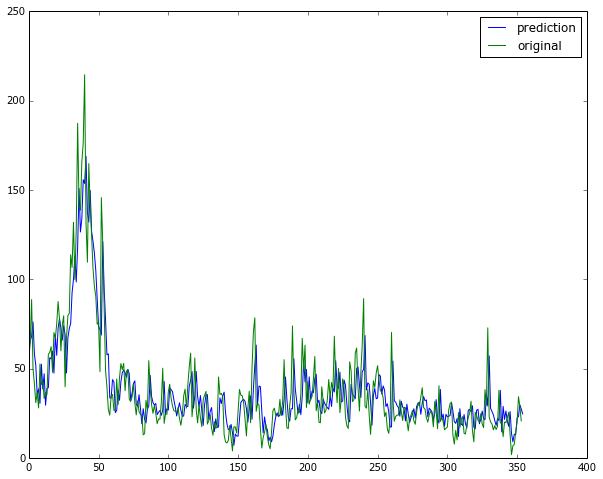

In [444]:
plt.figure(figsize=(10, 8))
plt.plot(predicted_prices, label='prediction')
plt.plot(daily_df['dam_lbmp'].values[10:], label='original')
plt.legend()

AR and EWMA analysis of data set

panel analysis of data set (forecast from weather)

talk about cool models